Project root on sys.path: /Users/andregrau/Desktop/Thesis/Python_Tool/simLIS



Verwendetes Szenario: office
Ladepunkte: 5
Zeitraum: 2025-12-01 00:00:00 bis 2025-12-10 23:45:00
Horizont: 10 Tage

📊 Sessions
Ankünfte mit Ladebedarf: 127
mit Ladezugang: 53
ohne Ladezugang (drive_off): 74
Nicht erreicht: 2


,session_id,vehicle_name,vehicle_class,arrival_time,departure_time,parking_hours,delivered_energy_kwh,remaining_energy_kwh,charger_id
0,2025-12-05_1,iX xDrive50,PKW,2025-12-05 06:37:26.122467,2025-12-05 07:15:50.178471,0.640016,35.625,21.839796,1
1,2025-12-01_0,i4 xDrive40,PKW,2025-12-01 07:02:03.580780,2025-12-01 07:41:43.409132,0.661063,23.750,3.282686,0


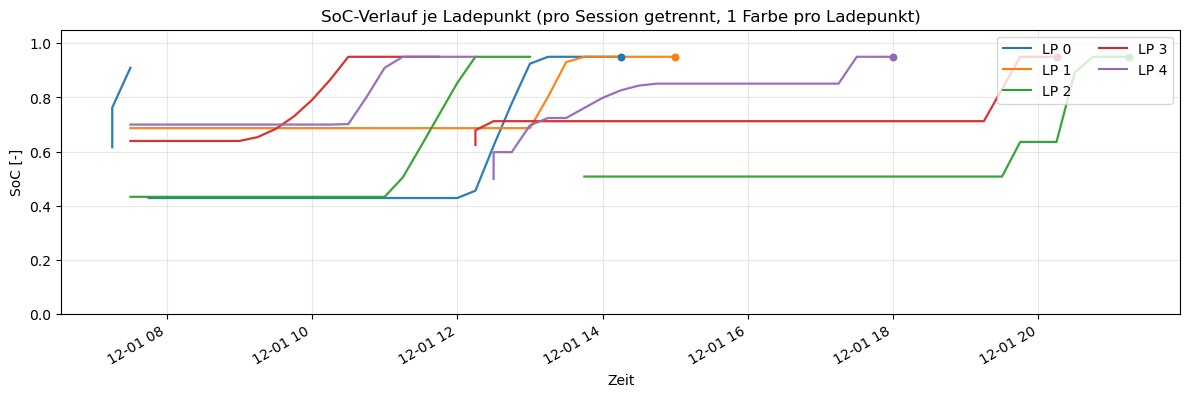

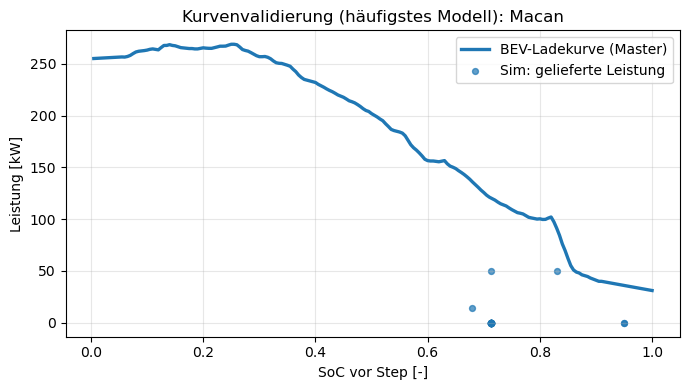

Verstöße: 0


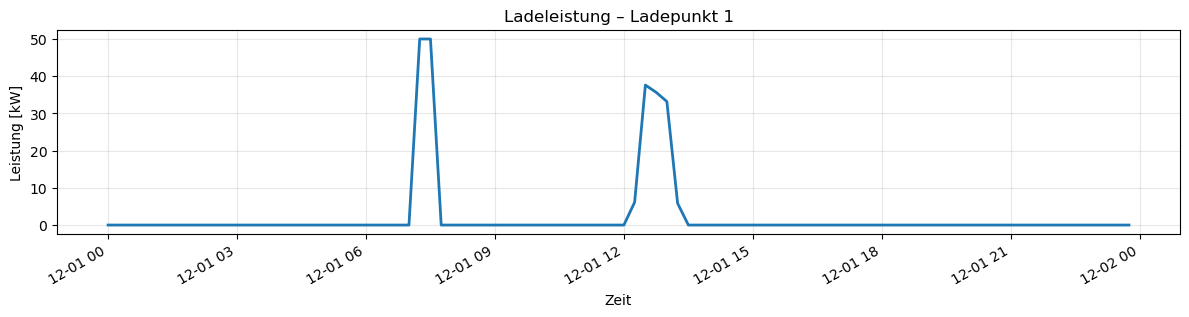

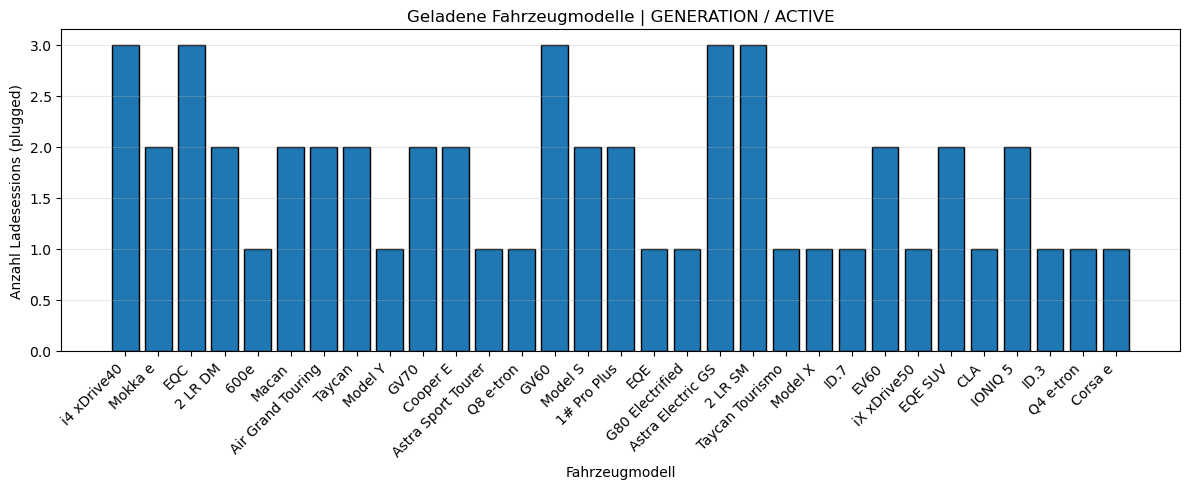

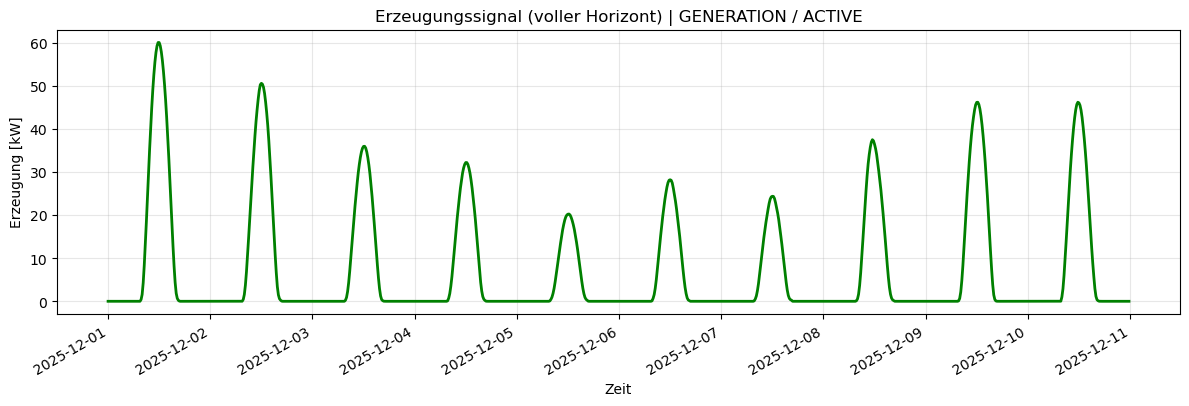

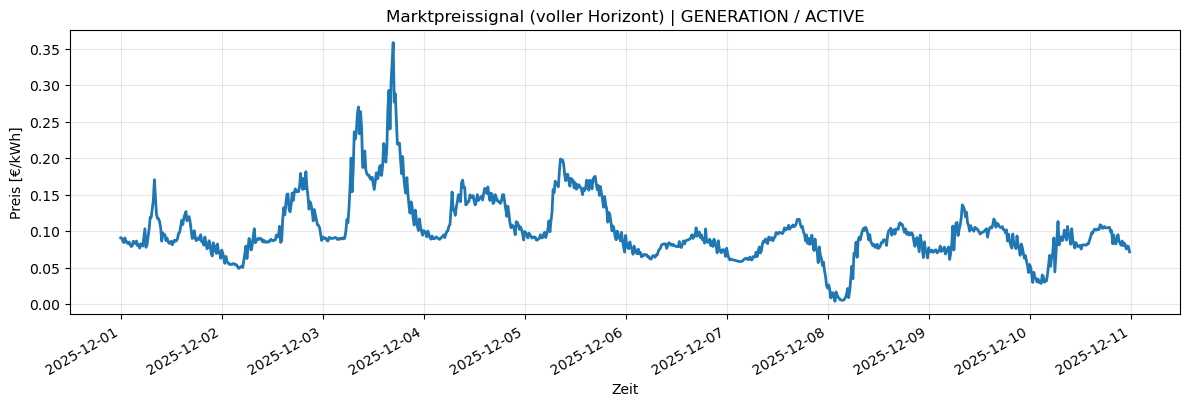

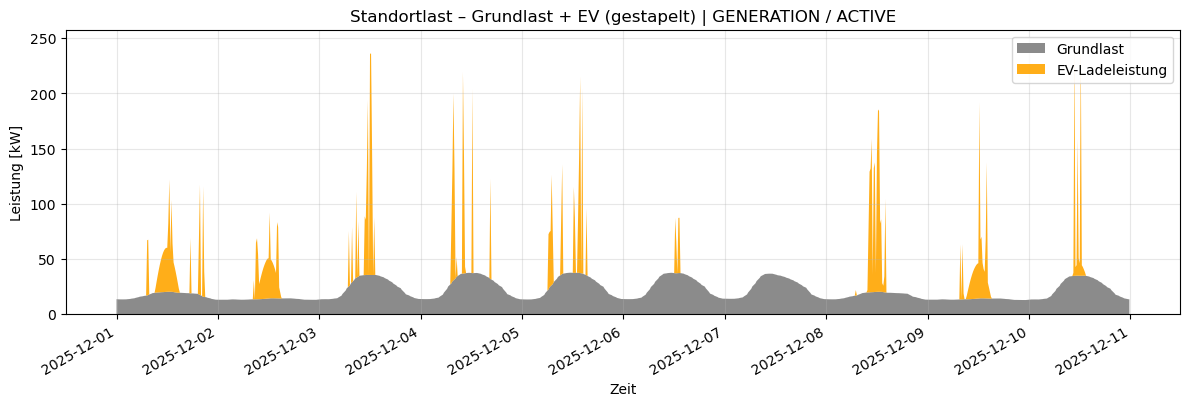

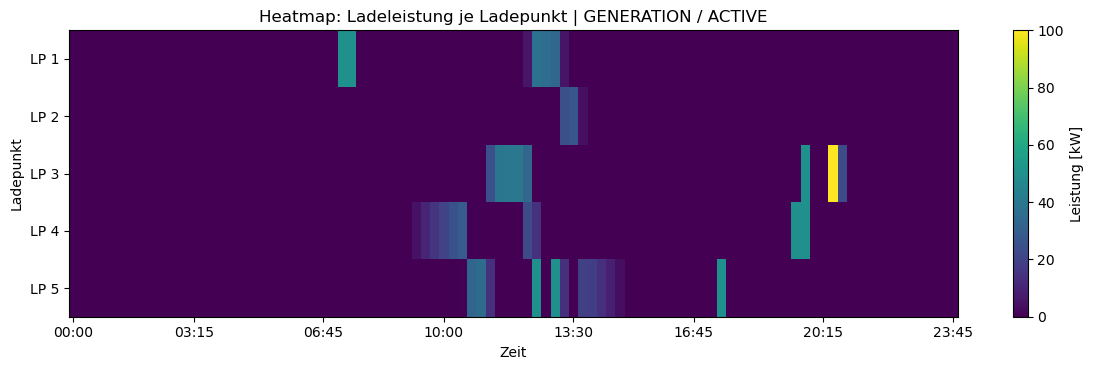

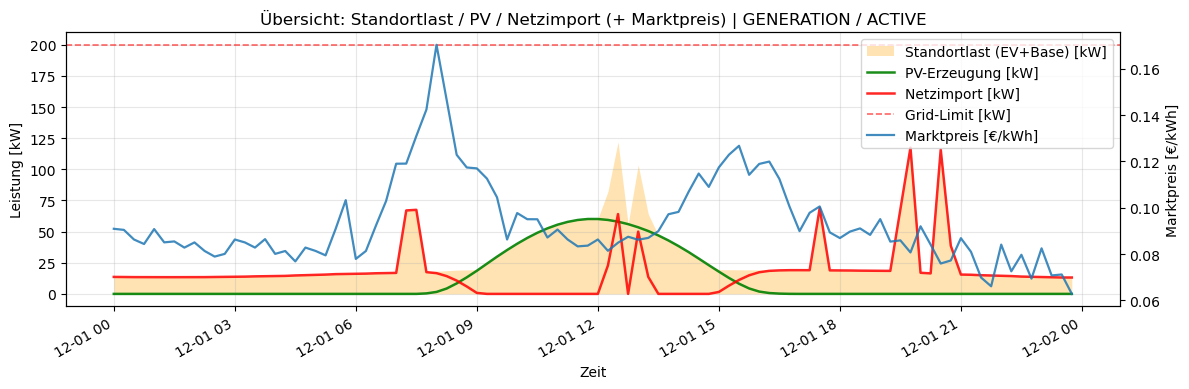

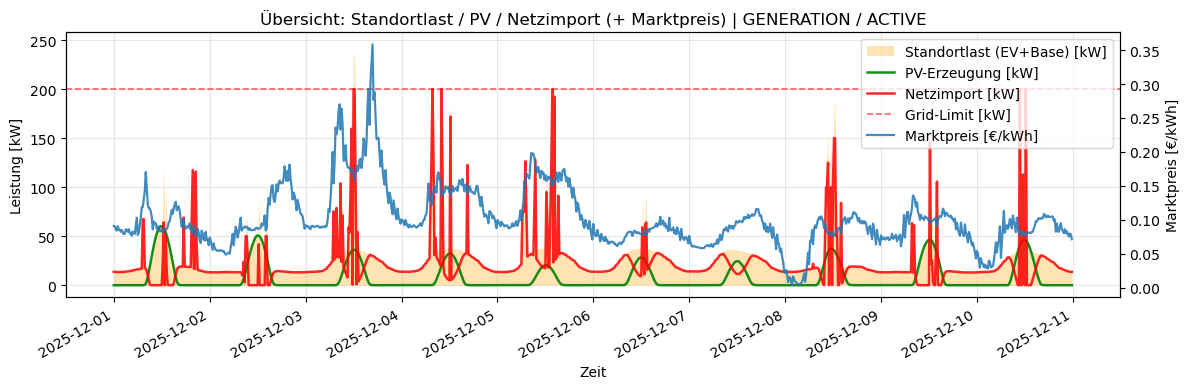

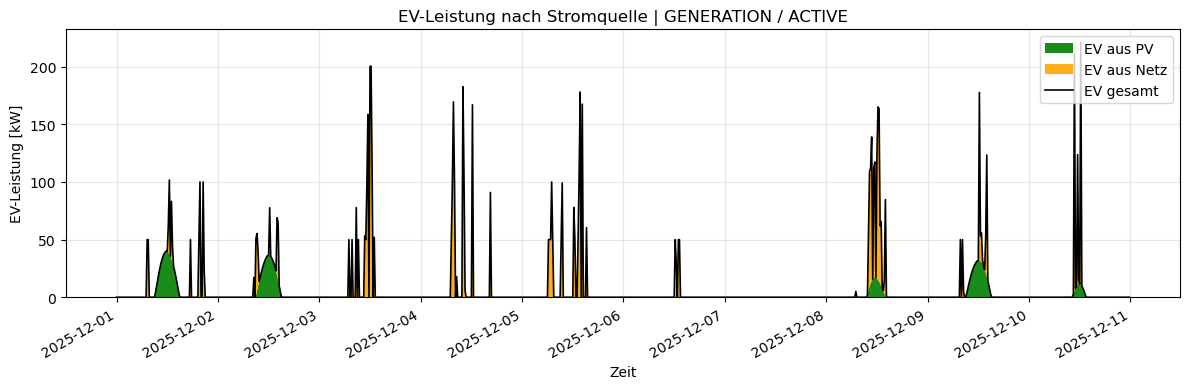

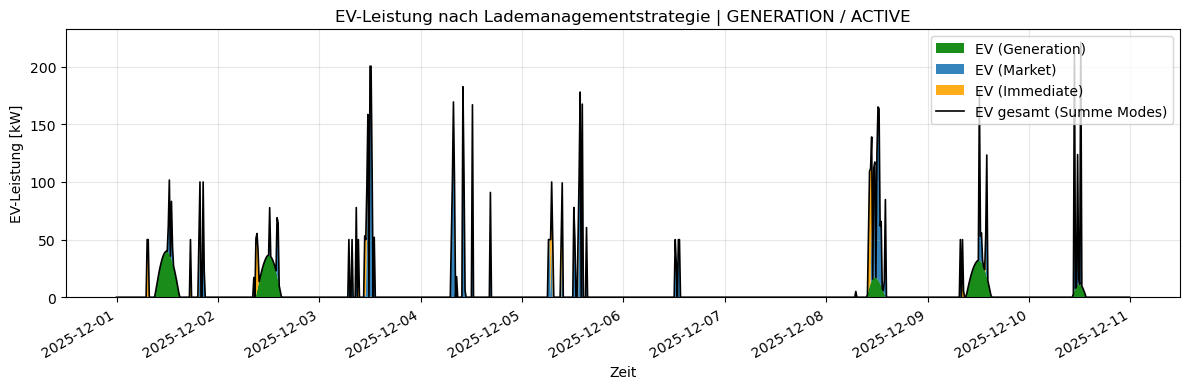

,vehicle_name,date,arrival_time,departure_time,parking_hours,delivered_energy_kwh,remaining_energy_kwh,charger_id
0,i4 xDrive40,2025-12-01,07:02,07:41,0.66,23.75,3.28,0
1,Mokka e,2025-12-01,07:18,15:11,7.88,13.16,0.00,1
2,i4 xDrive40,2025-12-01,07:19,13:09,5.84,41.84,0.00,2
3,EQC,2025-12-01,07:19,11:52,4.54,24.84,0.00,3
4,2 LR DM,2025-12-01,07:27,12:24,4.95,19.50,0.00,4
5,600e,2025-12-01,07:32,14:22,6.83,28.13,0.00,0
6,Macan,2025-12-01,12:02,20:24,8.37,32.52,0.00,3
7,Air Grand Touring,2025-12-01,12:21,18:12,5.85,54.08,0.00,4
8,Taycan,2025-12-01,13:38,21:22,7.73,41.08,0.00,2
9,Model Y,2025-12-02,07:12,14:44,7.53,42.31,0.00,0



🧩 Nutzung der Lademodi – Sessions
Sessions mit Ladevorgang: 53
PV: 20
Market: 38
Immediate: 17
Mehrere Modi: 19

⚡ Energie nach Modus [kWh]
Generation: 462.38
Market:     1185.04
Immediate:  352.85


In [ ]:
# =============================================================================
# A) Scenario Setup
# =============================================================================
scenario_name = "office"
scenario_path = f"../scenarios/{scenario_name}.yaml"

# Zoom-Fenster (Tage ab Start) – 1 = erster Tag
ZOOM_DAYS = 1

# =============================================================================
# B) Imports + Farben
# =============================================================================
import os
import sys
import warnings
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import display, HTML

warnings.simplefilter("always", UserWarning)

# Plot-Farben (global konsistent)
COLOR_GENERATION = "green"      # PV / generation
COLOR_MARKET     = "tab:blue"   # market
COLOR_IMMEDIATE  = "orange"     # immediate
COLOR_GRID       = "orange"     # EV aus Netz (bleibt orange)
COLOR_LOAD       = "orange"     # Standortlast-Fläche (wie gehabt)
COLOR_BASELOAD   = "#7f7f7f"
COLOR_TOTAL      = "black"      # Summenlinie

# =============================================================================
# C) Notebook UI Helpers
# =============================================================================
def show_strategy_status_html(charging_strategy: str, strategy_status: str) -> None:
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()
    color_map = {"ACTIVE": "#1a7f37", "INACTIVE": "#c62828", "IMMEDIATE": "#616161"}
    emoji_map = {"ACTIVE": "🟢", "INACTIVE": "🔴", "IMMEDIATE": "⚪"}
    color = color_map.get(status, "#616161")
    emoji = emoji_map.get(status, "⚪")

    html = f"""
    <div style="font-size:18px;font-weight:800;color:{color};
                padding:10px 12px;border:2px solid {color};border-radius:12px;
                display:flex;align-items:center;gap:10px;width:fit-content;
                margin:8px 0 14px 0; background: rgba(0,0,0,0.02);">
      <span style="font-size:22px">{emoji}</span>
      <div>
        <div>Charging strategy: <span style="letter-spacing:0.5px">{strat}</span></div>
        <div>Strategy status: <span style="letter-spacing:0.5px">{status}</span></div>
      </div>
    </div>
    """
    display(HTML(html))

def decorate_title_with_status(base_title: str, charging_strategy: str, strategy_status: str) -> str:
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()
    return f"{base_title} | {strat} / {status}"

def init_time_window(timestamps, scenario: dict, days: int = 1):
    """
    Zoom-Fenster (t0, t1) basierend auf Zeitschrittauflösung.
    Gibt zusätzlich steps_per_day zurück.
    """
    if timestamps is None or len(timestamps) == 0:
        return None, None, None
    steps_per_day_local = int(24 * 60 / int(scenario["time_resolution_min"]))
    steps = int(max(1, days)) * steps_per_day_local
    t0_local = pd.to_datetime(timestamps[0])
    t1_local = pd.to_datetime(timestamps[min(len(timestamps) - 1, steps - 1)])
    return steps_per_day_local, t0_local, t1_local

# =============================================================================
# D) Projektpfad robust setzen (fix für: ModuleNotFoundError: No module named 'model')
# =============================================================================
def ensure_project_root_on_syspath():
    """
    Fügt das Projekt-Root (Ordner, der 'model/' enthält) nach sys.path[0] hinzu.
    Funktioniert robust unabhängig davon, wo das Notebook gestartet wurde.
    """
    cwd = Path.cwd().resolve()
    candidates = [cwd] + list(cwd.parents)

    for p in candidates:
        if (p / "model").exists() and (p / "model").is_dir():
            root = str(p)
            if root not in sys.path:
                sys.path.insert(0, root)
            return root

    # Fallback: typischer Notebook-Pfad: notebooks/ -> root = .. (parent)
    fallback = str((cwd / "..").resolve())
    if fallback not in sys.path:
        sys.path.insert(0, fallback)
    return fallback

project_root = ensure_project_root_on_syspath()
print("Project root on sys.path:", project_root)

# =============================================================================
# E) Imports aus Simulation (gekürzt, alles aus simulation.py ziehen)
# =============================================================================
from model.simulation import load_scenario, simulate_load_profile

# KPI/Reporting (soll in simulation.py unter "Reporting / KPI Helper (Notebook)" liegen)
from model.simulation import (
    build_base_load_series,
    summarize_sessions,
    get_daytype_calendar,
    group_sessions_by_day,
)

# Optional (wenn in deiner simulation.py vorhanden)
try:
    from model.simulation import build_strategy_signal_series
except Exception:
    build_strategy_signal_series = None

try:
    from model.simulation import build_pv_unused_table
except Exception:
    build_pv_unused_table = None

try:
    from model.simulation import summarize_sessions_by_charging_mode, summarize_energy_by_charging_mode
except Exception:
    summarize_sessions_by_charging_mode = None
    summarize_energy_by_charging_mode = None

# Plot-/Notebook-Helper (die sollten idealerweise in simulation.py liegen)
# -> Wenn dir hier was fehlt, sag mir einfach die Import-Fehlermeldung, dann passt du simulation.py an.
from model.simulation import (
    make_timeseries_df,
    plot_soc_by_chargers,
    validate_against_master_curves,
    plot_power_per_charger,
    plot_site_overview,
    plot_charger_power_heatmap,
    plot_ev_power_by_source_stack,
    plot_ev_power_by_mode_stack_from_cols,
    build_plugged_sessions_preview_table,
)

# =============================================================================
# F) Simulation ausführen
# =============================================================================
scenario = load_scenario(scenario_path)

(
    timestamps,
    load_kw,
    sessions,
    charging_counts,
    holiday_dates,
    charging_strategy,
    strategy_status,
    debug_rows,
    charger_traces,
) = simulate_load_profile(
    scenario,
    record_debug=True,
    record_charger_traces=True,
)

show_strategy_status_html(charging_strategy, strategy_status)

df_tr = pd.DataFrame(charger_traces if charger_traces is not None else [])
steps_per_day, t0, t1 = init_time_window(timestamps=timestamps, scenario=scenario, days=ZOOM_DAYS)

# =============================================================================
# G) Strategie-Signale (PV/Market) optional laden (für zusätzliche Plots/Overlay)
# =============================================================================
generation_series = generation_ylabel = None
market_series = market_ylabel = None

if build_strategy_signal_series is not None:
    # PV-Signal für generation
    try:
        generation_series, generation_ylabel = build_strategy_signal_series(
            scenario=scenario,
            timestamps=timestamps,
            charging_strategy="generation",
            normalize_to_internal=True,
            strategy_resolution_min=15,
        )
    except Exception:
        generation_series = generation_ylabel = None

    # Market-Signal (auch wenn Strategie nicht market ist – fürs Overlay/Debug)
    try:
        market_series, market_ylabel = build_strategy_signal_series(
            scenario=scenario,
            timestamps=timestamps,
            charging_strategy="market",
            normalize_to_internal=True,
            strategy_resolution_min=15,
        )
    except Exception:
        market_series = market_ylabel = None

# =============================================================================
# H) Timeseries DF (einheitliche “Source of Truth”)
# =============================================================================
df_ts = make_timeseries_df(
    timestamps=timestamps,
    ev_load_kw=load_kw,
    scenario=scenario,
    debug_rows=debug_rows,
    generation_series=generation_series,
    market_series=market_series,
)

# =============================================================================
# I) KPIs kurz
# =============================================================================
print("\nVerwendetes Szenario:", scenario_name)
print("Ladepunkte:", scenario["site"]["number_chargers"])
print("Zeitraum:", timestamps[0], "bis", timestamps[-1])
print("Horizont:", scenario["simulation_horizon_days"], "Tage")

summary = summarize_sessions(sessions)
print("\n📊 Sessions")
print("Ankünfte mit Ladebedarf:", summary["num_sessions_total"])
print("mit Ladezugang:", summary["num_sessions_plugged"])
print("ohne Ladezugang (drive_off):", summary["num_sessions_rejected"])

df_not_reached = pd.DataFrame(summary["not_reached_rows"])
if len(df_not_reached) == 0:
    print("Alle BEV haben Ziel-SoC erreicht.")
else:
    df_not_reached = df_not_reached.sort_values("remaining_energy_kwh", ascending=False).reset_index(drop=True)
    print("Nicht erreicht:", len(df_not_reached))
    display(df_not_reached)

# =============================================================================
# J) Daytype Kalender + Gruppierung (optional, aber “wie früher”)
# =============================================================================
start_dt = datetime.fromisoformat(scenario["start_datetime"])
horizon_days = int(scenario["simulation_horizon_days"])

days_by_type_calendar = get_daytype_calendar(
    start_datetime=start_dt,
    horizon_days=horizon_days,
    holiday_dates=holiday_dates,
)
sessions_by_day = group_sessions_by_day(sessions, only_plugged=False)
sessions_by_day_plugged = group_sessions_by_day(sessions, only_plugged=True)

# =============================================================================
# K) PLOTS – alle wie früher (Zoom + Vollhorizont)
# =============================================================================

# 1) SoC je Ladepunkt (Zoom)
plot_soc_by_chargers(
    df_tr=df_tr,
    charger_ids=list(range(int(scenario["site"]["number_chargers"]))),
    start=t0,
    end=t1,
    use_raw=True,
)

# 2) Kurvenvalidierung (Zoom)
d_curvecheck, viol = validate_against_master_curves(df_tr, sessions, scenario, start=t0, end=t1)
print("Verstöße:", len(viol))
if len(viol):
    display(viol.sort_values("power_kw", ascending=False).head(10))

# 3) Leistung einzelner Ladepunkte (Zoom)
plot_power_per_charger(df_tr, charger_id=0, start=t0, end=t1)

# 4) Fahrzeugzählung (plugged Sessions)
sessions_plugged = [s for s in sessions if s.get("_plug_in_time") is not None]
counts = Counter([s.get("vehicle_name", "") for s in sessions_plugged])

plt.figure(figsize=(12, 5))
plt.bar(list(counts.keys()), list(counts.values()), edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Fahrzeugmodell")
plt.ylabel("Anzahl Ladesessions (plugged)")
plt.title(decorate_title_with_status("Geladene Fahrzeugmodelle", charging_strategy, strategy_status))
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 5) Strategy-only Plots (voller Horizont)
if generation_series is not None and generation_ylabel is not None:
    plt.figure(figsize=(12, 4))
    plt.plot(timestamps, generation_series, linewidth=2, color=COLOR_GENERATION)
    plt.xlabel("Zeit")
    plt.ylabel(generation_ylabel)
    plt.title(decorate_title_with_status("Erzeugungssignal (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()

if market_series is not None and market_ylabel is not None:
    plt.figure(figsize=(12, 4))
    plt.plot(timestamps, market_series, linewidth=2, color=COLOR_MARKET)
    plt.xlabel("Zeit")
    plt.ylabel(market_ylabel)
    plt.title(decorate_title_with_status("Marktpreissignal (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()

# 6) Gestapelte Standortlast (Base + EV) – voller Horizont
plt.figure(figsize=(12, 4))
plt.stackplot(
    df_ts["ts"],
    df_ts["base_load_kw"],
    df_ts["ev_load_kw"],
    labels=["Grundlast", "EV-Ladeleistung"],
    colors=[COLOR_BASELOAD, COLOR_LOAD],
    alpha=0.9,
)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(decorate_title_with_status("Standortlast – Grundlast + EV (gestapelt)", charging_strategy, strategy_status))
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

# 7) Heatmap (Zoom) + Standort-Übersicht (Zoom + voller Horizont)
plot_charger_power_heatmap(df_tr, charging_strategy, strategy_status, start=t0, end=t1)

plot_site_overview(
    df_ts=df_ts,
    scenario=scenario,
    charging_strategy=charging_strategy,
    strategy_status=strategy_status,
    start=t0,
    end=t1,
)

plot_site_overview(
    df_ts=df_ts,
    scenario=scenario,
    charging_strategy=charging_strategy,
    strategy_status=strategy_status,
)

# 8) EV-Leistung nach Quelle (PV vs Netz) – Farben: PV grün, Netz orange
src = plot_ev_power_by_source_stack(
    df_tr=df_tr,
    df_ts=df_ts,
    title=decorate_title_with_status("EV-Leistung nach Stromquelle", charging_strategy, strategy_status),
)

# 9) EV-Leistung nach Mode (generation / market / immediate) – Farben: grün / blau / orange
modes = plot_ev_power_by_mode_stack_from_cols(
    df_tr=df_tr,
    df_ts=df_ts,
    title=decorate_title_with_status("EV-Leistung nach Lademanagementstrategie", charging_strategy, strategy_status),
)

# 10) Plugged Sessions Preview
display(build_plugged_sessions_preview_table(sessions, n=20))

# 11) Debugging: Nutzung der Lademodi (optional)
if summarize_sessions_by_charging_mode is not None and summarize_energy_by_charging_mode is not None:
    mode_counts = summarize_sessions_by_charging_mode(sessions)
    mode_energy = summarize_energy_by_charging_mode(sessions)

    print("\n🧩 Nutzung der Lademodi – Sessions")
    print("Sessions mit Ladevorgang:", mode_counts["sessions_with_any_charging"])
    print("PV:", mode_counts["sessions_charged_with_generation"])
    print("Market:", mode_counts["sessions_charged_with_market"])
    print("Immediate:", mode_counts["sessions_charged_with_immediate"])
    print("Mehrere Modi:", mode_counts["sessions_with_multiple_modes"])

    print("\n⚡ Energie nach Modus [kWh]")
    print(f"Generation: {mode_energy['generation']:.2f}")
    print(f"Market:     {mode_energy['market']:.2f}")
    print(f"Immediate:  {mode_energy['immediate']:.2f}")